In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

import chromatix.functional as cx
from chromatix.ops import init_plane_resample
import jax
from jax import Array
import jax.numpy as jnp
import optax
from jaxopt.projection import projection_non_negative
from flax import linen as nn
from flax.core import unfreeze, freeze

from xpc.psf import apply_psf
from xpc.transformations import rotate_volume_4d
from xpc.xscatter import get_delta_beta_mix, get_wavenum, get_wavelen


class Material:
    def __init__(self, name, matcomp, density):
        self.name = name
        self.matcomp = matcomp
        self.density = density
    def delta_beta(self, energy):
        delta, beta = get_delta_beta_mix(self.matcomp, np.atleast_1d(energy), self.density)
        return delta.squeeze(), beta.squeeze()

tissue = Material('tissue', 'H(10.2)C(14.3)N(3.4)O(70.8)Na(0.2)P(0.3)S(0.3)Cl(0.2)K(0.3)', 1.06)
bone = Material('bone', 'H(3.4)C(15.5)N(4.2)O(43.5)Na(0.1)Mg(0.2)P(10.3)S(0.3)Ca(22.5)', 1.92)


# Overview

Our goal is to perform material decomposition, where we take as input x-ray images (or CT scans) acquired with 2 or more different energies and then solve for "basis material images" (or volumes). In these "BMIs", each pixel (or voxel) represents a projected thickness (or density) of some material of interest. In clinical imaging, this is generally done with a material basis of bone and tissue. 

There are established analytical methods for performing material decomposition. However, for x-ray images with propagation-based phase contrast, these methods are highly approximate. So I want to use the automatic differentiation capability of chromatix to iteratively solve for the basis material images and hopefully demonstrate better performance relative to the analytical methods.

All distances are in units [m], energies in [keV]. `I0` is the incident beam intensity, which controls the noise level. 

# Forward model

In [2]:
%%time
    
class MultiMatPBI(nn.Module):        
    # Simulation settings
    propdist = 50e-3
    energies = jnp.array([24, 34])  
    material_basis = {1:tissue, 2:bone}   
             
    # Phantom
    phantom_fov: float = 0.625e-3  
    phantom_Nx: int = 64
    phantom_Ny: int = 20  # smaller vertical plane
    phantom_dx: float = phantom_fov / phantom_Nx

    # Detector
    det_Nx: int = phantom_Nx   # for now, set the same.
    det_Ny: int = phantom_Ny
    det_fwhm: float = 10e-6
    det_psf: str = 'lorentzian' 
    resampling_method: str = 'linear'
    I0: int = 1e11 / (phantom_Nx**2) # should normalize this to pixel size later

    # Misc.
    ds1, bs1 = material_basis[1].delta_beta(energies)
    ds2, bs2 = material_basis[2].delta_beta(energies)
    n1 = (ds1 + 1j*bs1) / material_basis[1].density  # normalized to the default density!!
    n2 = (ds2 + 1j*bs2) / material_basis[2].density
    det_fov: float = phantom_fov
    det_dx: float = det_fov / det_Nx
    wavelens = get_wavelen(energies)
    N_pad: int = 100
    n_medium: float = 1  

    def setup(self):
        
        # initialize empty volume (last axis used for basis material, voxels represent density)
        self.volume = self.param(
            'volume',
            lambda key, shape: jnp.full(shape, 1e-3, dtype=jnp.float32),
            (self.phantom_Nx, self.phantom_Ny, self.phantom_Nx, len(self.material_basis)),
        )

        # function to resample source field to detectory geometry
        self.det_resample_func = init_plane_resample(
            (self.det_Nx, self.det_Ny), 
            (self.det_dx, self.det_dx), 
            resampling_method=self.resampling_method
        )
    
    def __call__(self, angle: float) -> Array:
        # convert the density phantom to beta, delta at the beam energies
        Nx, Ny, Nz = self.phantom_Nx, self.phantom_Ny, self.phantom_Nx
        vol_db_mat1 = jnp.tile(self.n1, [Nx, Ny, Nz]).reshape([Nx, Ny, Nz, 2]) 
        vol_db_mat2 = jnp.tile(self.n2, [Nx, Ny, Nz]).reshape([Nx, Ny, Nz, 2]) 
        volume = vol_db_mat1 * jnp.stack([self.volume[:,:,:,0], self.volume[:,:,:,0]], axis=-1) + vol_db_mat2 * jnp.stack([self.volume[:,:,:,1], self.volume[:,:,:,1]], axis=-1)
        volume = jnp.stack([volume.imag, volume.real], axis=0)

        # incident wave
        field = cx.plane_wave(
            shape = (self.phantom_Nx, self.phantom_Ny),
            dx = self.phantom_dx,
            spectrum = self.wavelens,
            spectral_density = jnp.ones(self.wavelens.size)
        ) 
        field = field / field.intensity.max()**0.5 / (self.phantom_Nx / self.det_Nx) / (self.phantom_Ny / self.det_Ny) 
        cval = field.intensity.max()

        # thru object
        rotated_vol = jax.vmap(
            rotate_volume_4d,
            in_axes=(0, None)
        )(volume, angle)
        vol_proj = jnp.sum(rotated_vol, axis=3)
        beta_proj = vol_proj[0, None, ..., None]
        dn_proj = vol_proj[1, None, ..., None]
        exit_field = cx.thin_sample(field, beta_proj, dn_proj, self.phantom_dx)

        # to detector
        det_field = cx.transfer_propagate(exit_field, self.propdist, self.n_medium, self.N_pad, cval=cval, mode='same')
        imgs = self.det_resample_func(det_field.amplitude.squeeze()[..., None], field.dx.ravel()[:1])[...,0]

        # detector nonidealities
        # imgs = jax.random.poisson(key, self.I0*imgs, imgs.shape) / self.I0  # noise
        imgs = jax.vmap(
            lambda img: apply_psf(img, self.det_fov, self.det_dx, psf=self.det_psf, fwhm=self.det_fwhm, kernel_width=0.1),
            in_axes = -1,
            out_axes = -1
        )(imgs)
        imgs = imgs.swapaxes(0,1)
        return imgs

# Set up model
key = jax.random.PRNGKey(3)
model = MultiMatPBI()
params = model.init(key, 0)

   

CPU times: user 11.2 s, sys: 1.67 s, total: 12.9 s
Wall time: 17.9 s


# Simulate raw data

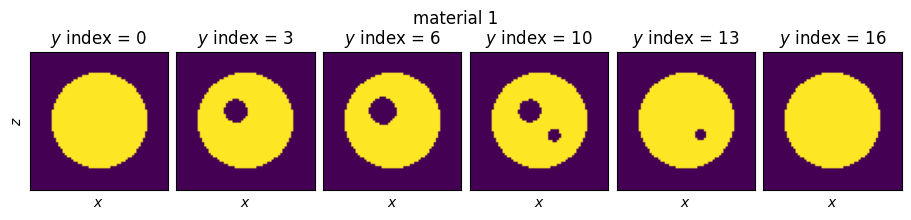

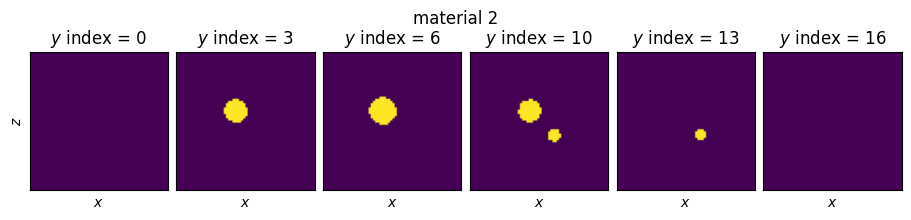

In [3]:
# Make a real phantom for simulating data.
# Create a 2-material raw volume. Note:
#   We first make a cubic volume `vol_raw` with shape (Nx, Nx, Nx). Then,
#   the "vertical" direction is clipped so the shape is (Nx, Ny, Nx), where Ny < Nx.
#   We do this to save space in memory, since in the end we only plan to look at
#   a central reconstructed y-slice in the final CT volume.

def make_raw_phantom(N, p0=1.0, p1=0.45, p2=0.35, c1=1, c2=1, id0=1, id1=2, id2=3, DTYPE=np.uint8):
    assert (p1 <= p0/2) and (p2 <= p0/2) and (p1 > 0) and (p2 > 0)
    coords = np.linspace(-N/2, N/2, N)
    Z, Y, X = np.meshgrid(coords, coords, coords)
    r1 = p1*N/2
    r2 = p2*N/2
    x1, y1, z1 = -c1*r1/np.sqrt(2), -c1*r1/np.sqrt(2), -r1/2
    x2, y2, z2 = c2*r2/np.sqrt(2), c2*r2/np.sqrt(2), r2/2
    obj = np.zeros([N,N,N], dtype=DTYPE)
    obj[np.where(X**2 + Y**2 < (p0*N/2)**2)] = id0
    obj[np.where((X-x1)**2 + (Y-y1)**2 + (Z-z1)**2 < r1**2)] = id1
    obj[np.where((X-x2)**2 + (Y-y2)**2 + (Z-z2)**2 < r2**2)] = id2
    return obj
    
Nx, Ny = model.phantom_Nx, model.phantom_Ny
vol_raw = make_raw_phantom(Nx, p0=0.7, p1=0.2, p2=0.1, id2=2, c1=1, c2=3)
subvol_raw = vol_raw[:,(Nx-Ny)//2:(Nx+Ny)//2,:]

density_phantom = np.zeros([Nx, Ny, Nx, len(model.material_basis)])
for i, item in enumerate(model.material_basis.items()):
    idx, mat = item
    density_phantom[:,:,:,i][subvol_raw==idx] = mat.density     

# View the phantom
for m in range(2):  # 2 materials
    fig, ax = plt.subplots(1, 6, figsize=[9,2], sharey=True, layout='constrained')
    fig.suptitle(f'material {m+1}')
    for i in range(len(ax)):
        yslice = i*Ny//len(ax)
        ax[i].imshow(density_phantom[:,yslice,:,m])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlabel('$x$')
        ax[0].set_ylabel('$z$')
        ax[i].set_title(f'$y$ index = {yslice}')
    plt.show()


In [4]:
%%time 

# For simulation, replace the params with the phantom data (instead of the zeros).
params = unfreeze(params)
params['params']['volume'] = density_phantom
params = freeze(params)

# Define the CT rotation angles
tot_theta = jnp.pi  
N_theta = 100
thetas = jnp.linspace(0, tot_theta*(1-1/N_theta), N_theta)

# Simulate
forward = jax.jit(jax.vmap(model.apply, in_axes=(None, 0)))
data = forward(params, thetas)
data = jax.random.poisson(key, model.I0*data, data.shape) / model.I0  # add noise


CPU times: user 6.54 s, sys: 252 ms, total: 6.79 s
Wall time: 6.8 s


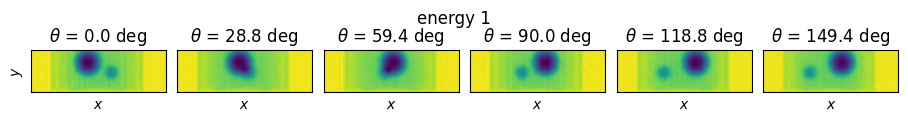

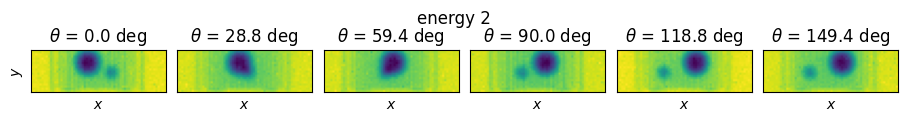

In [5]:
# View the simulated raw data.
# For each rotation angle, we have a single projection at each energy.

for e in range(2):  # 2 energies
    fig, ax = plt.subplots(1, 6, figsize=[9,1], sharey=True, layout='constrained')
    fig.suptitle(f'energy {e+1}')
    for i in range(len(ax)):
        i_theta = i*N_theta//len(ax)
        ax[i].imshow(data[i_theta,:,:,e])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_xlabel('$x$')
        ax[0].set_ylabel('$y$')
        ax[i].set_title(f'$\\theta$ = {180*thetas[i_theta]/jnp.pi:.1f} deg')
    plt.show()

# Optimization

In [6]:
# A function to easily visualize the optimization's progress at each iteration.
# We are optimizing the entire 3D volume at once, but for easy visualization,
# this just shows the central y-slice. For NY = 20, this means y index = 10.
def show_compare(params, loss, vol_truth, kw={'vmin':0, 'vmax':2, 'cmap':'bwr'}):
    vol1 = params['params']['volume']
    y_index = vol1.shape[1]//2
    
    fig, ax = plt.subplots(1,3,figsize=[10,3], dpi=300, layout='constrained')
    
    ax[0].plot(loss)
    ax[0].set_title('loss')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('iteration #')
    
    for i in range(2):
        axi = ax[i+1]
        m = axi.imshow(vol1[:,y_index,:,i] / model.material_basis[i+1].density, **kw) 
        axi.set_title(f'material {i+1}')
        axi.set_xticks([])
        axi.set_yticks([])
        axi.set_xlabel('$x$')
        axi.set_ylabel('$z$')
        
    fig.colorbar(m, ax=ax)
    plt.show()

# Regularization functions for the loss function:
def TV(img, axes=[0,1,2]):  
    tot_grad = 0
    for axi in axes:
        tot_grad += jnp.sum(jnp.abs(jnp.diff(img, axis=axi)))  
    return tot_grad
    
def L1(img):
    return jnp.abs(img).sum()

loss @ iter 0: 4.591e+00 (t = 6.7 s)


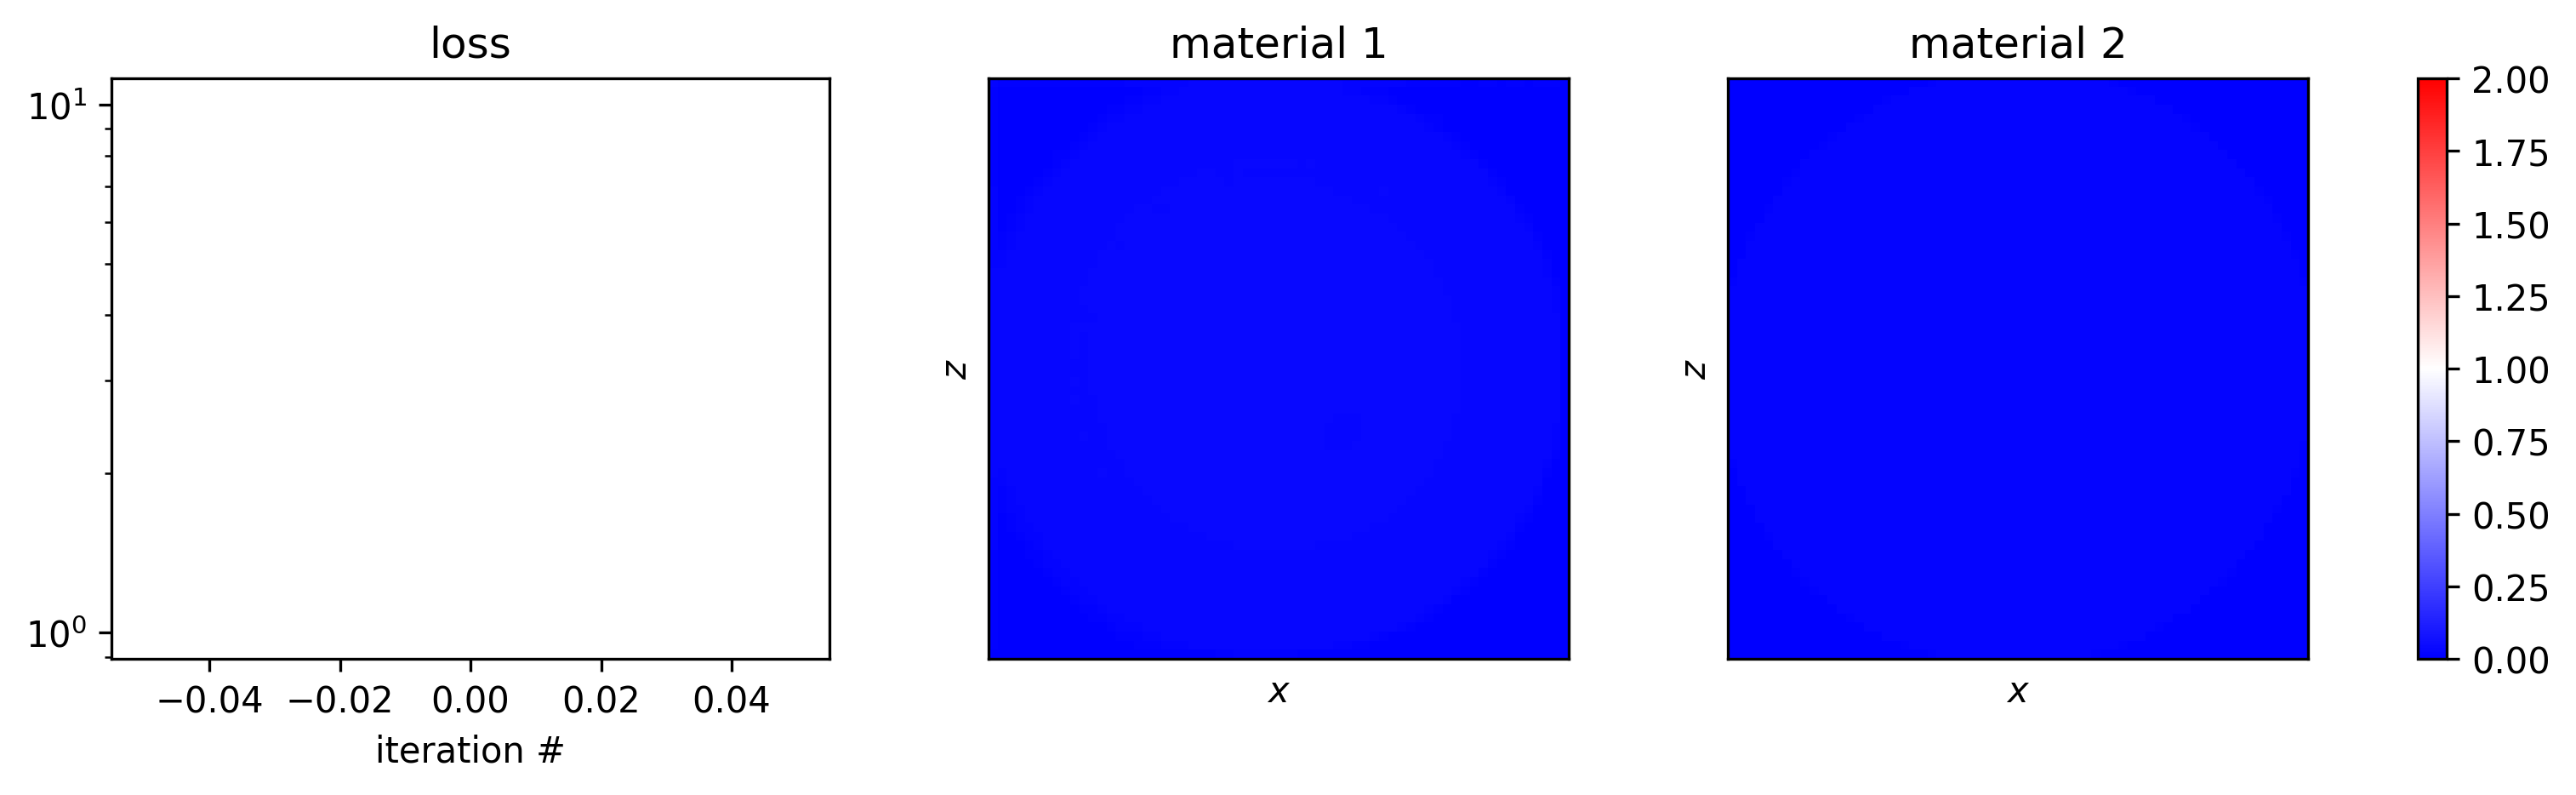

loss @ iter 100: 8.020e-01 (t = 10.3 s)


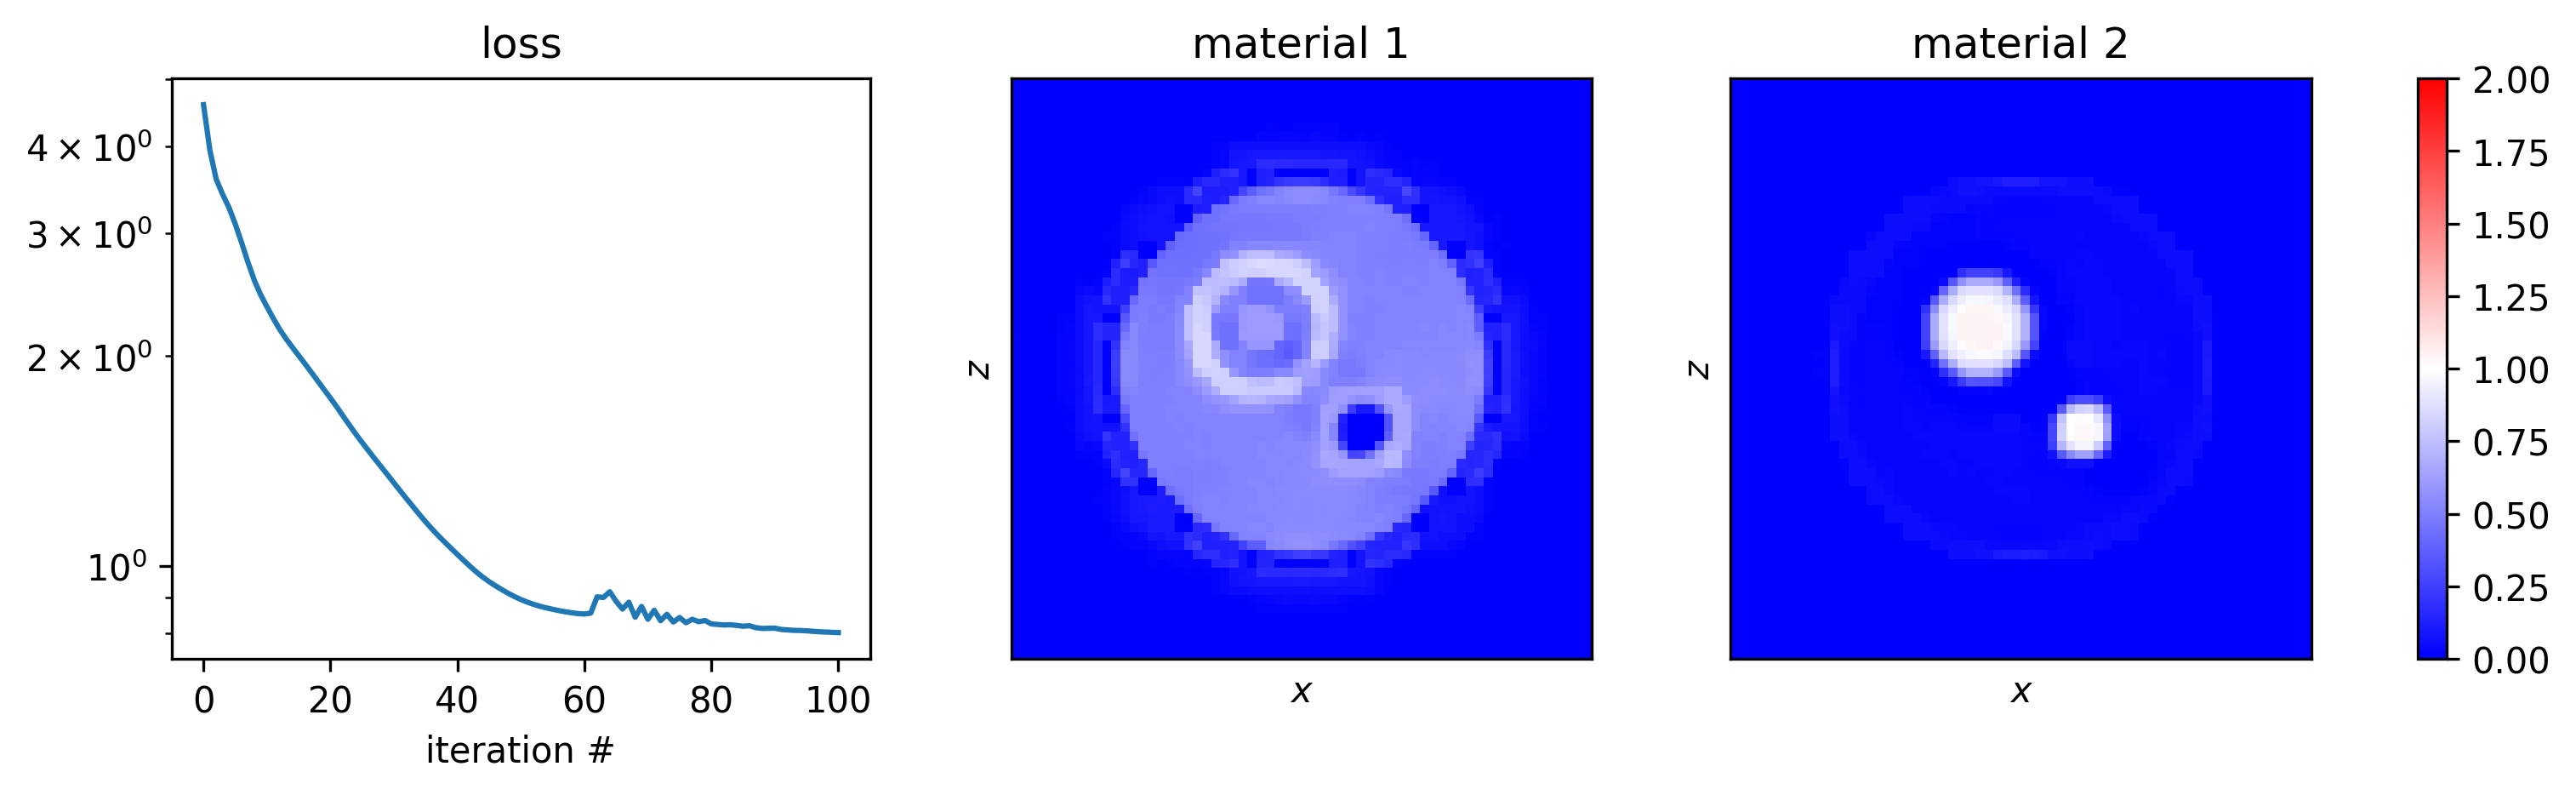

loss @ iter 200: 7.676e-01 (t = 13.8 s)


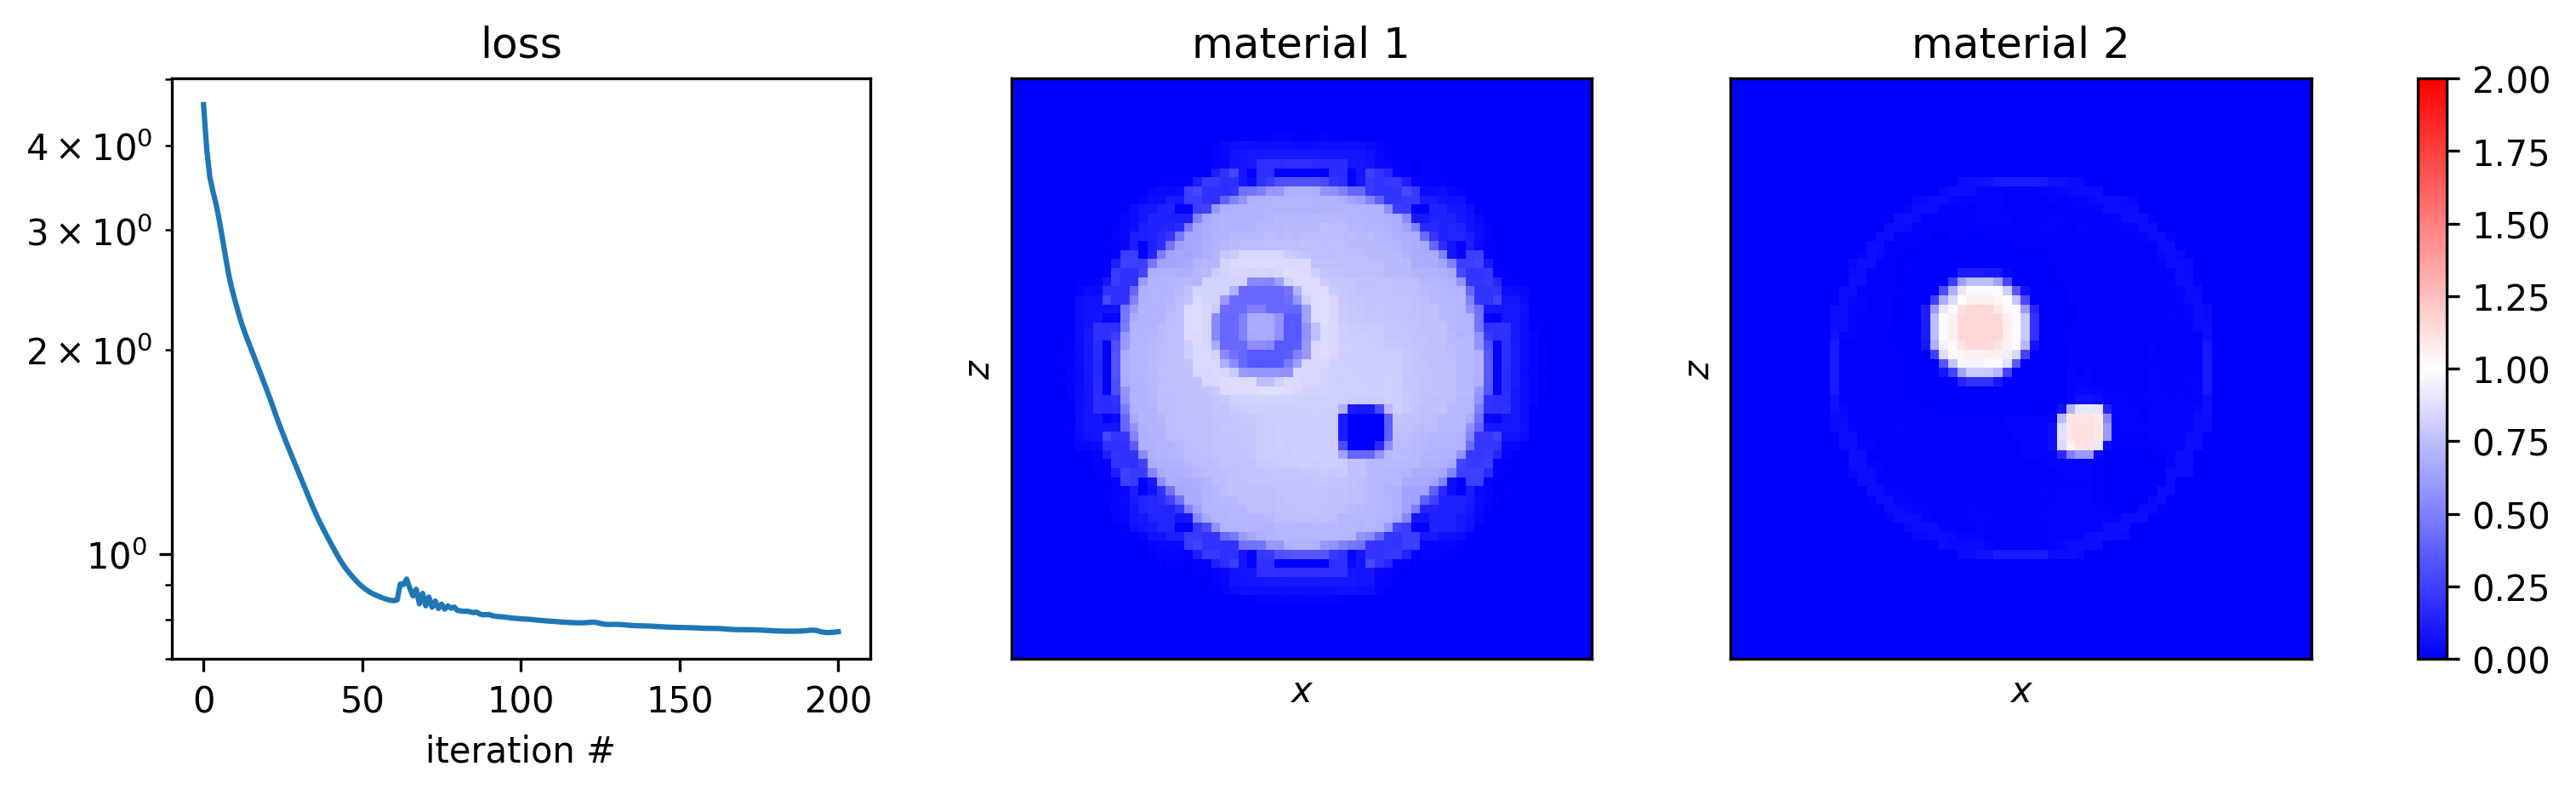

loss @ iter 300: 7.354e-01 (t = 17.2 s)


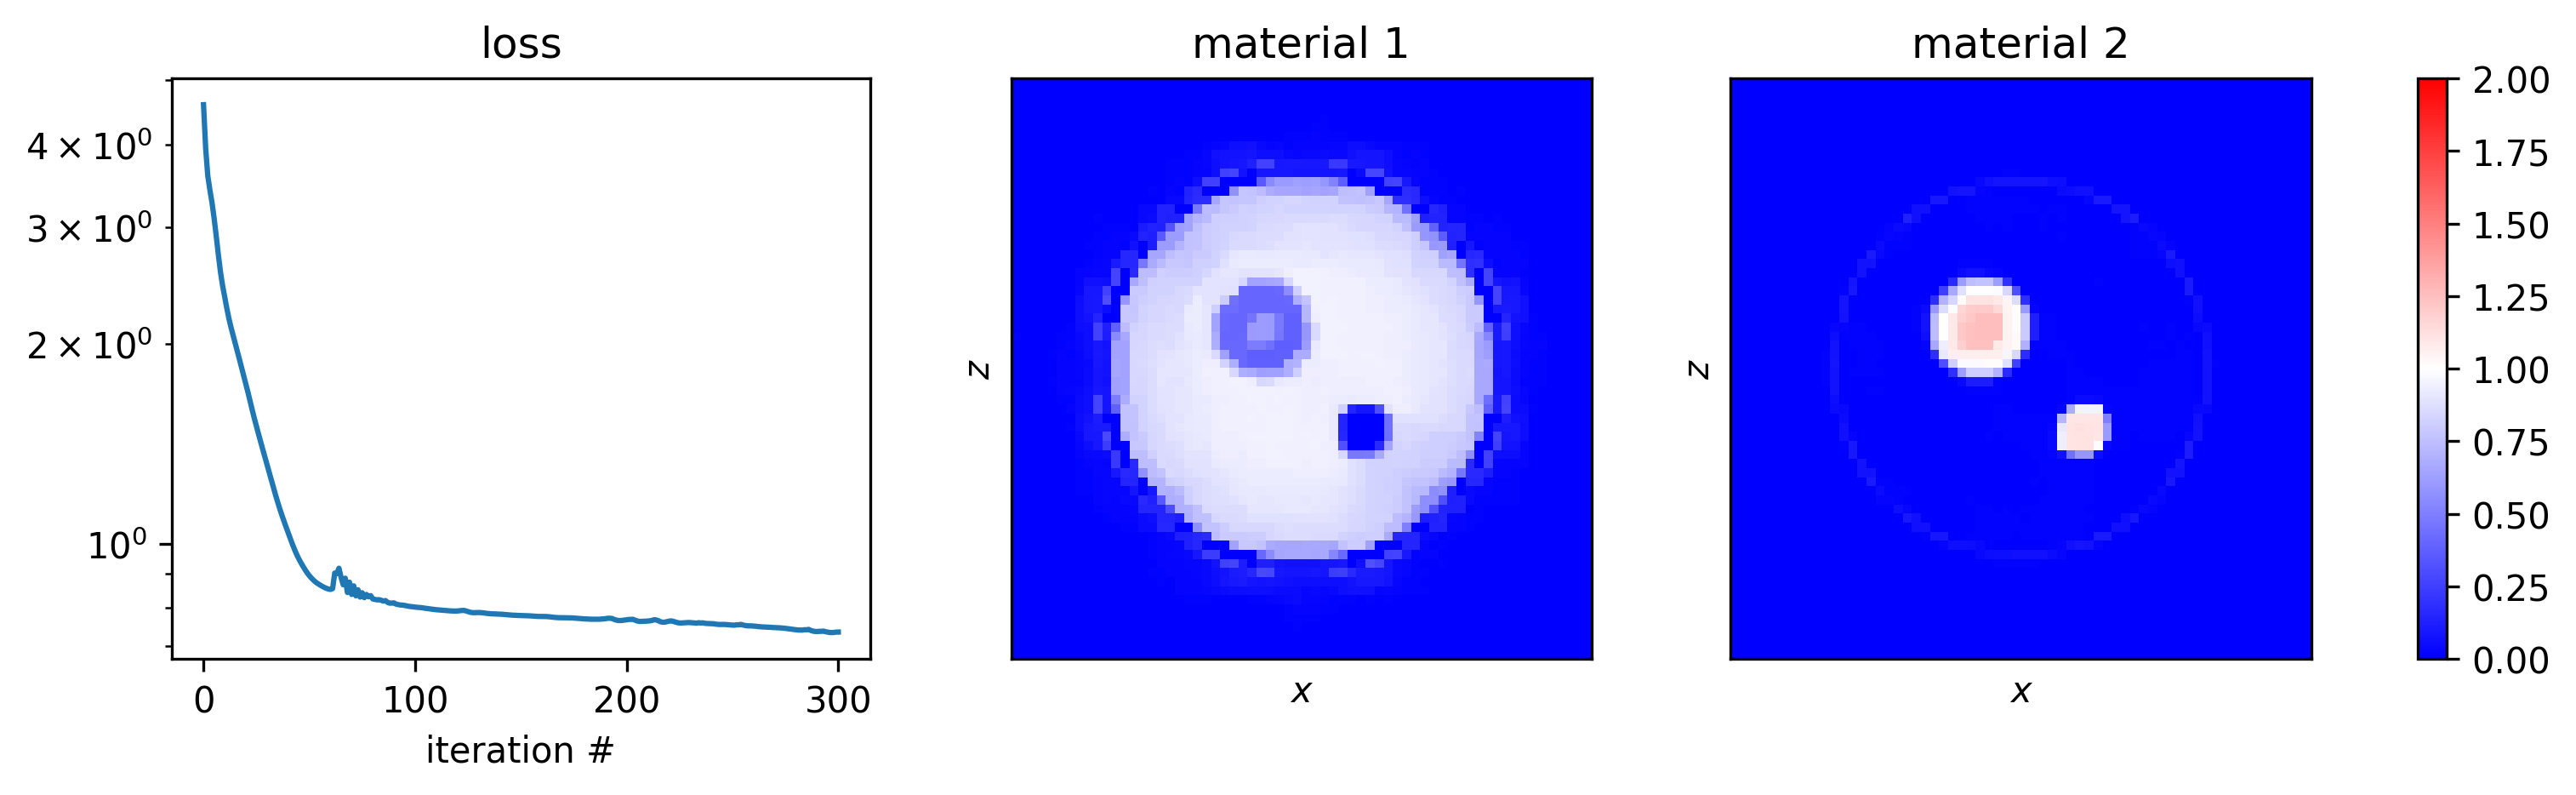

loss @ iter 400: 7.206e-01 (t = 20.5 s)


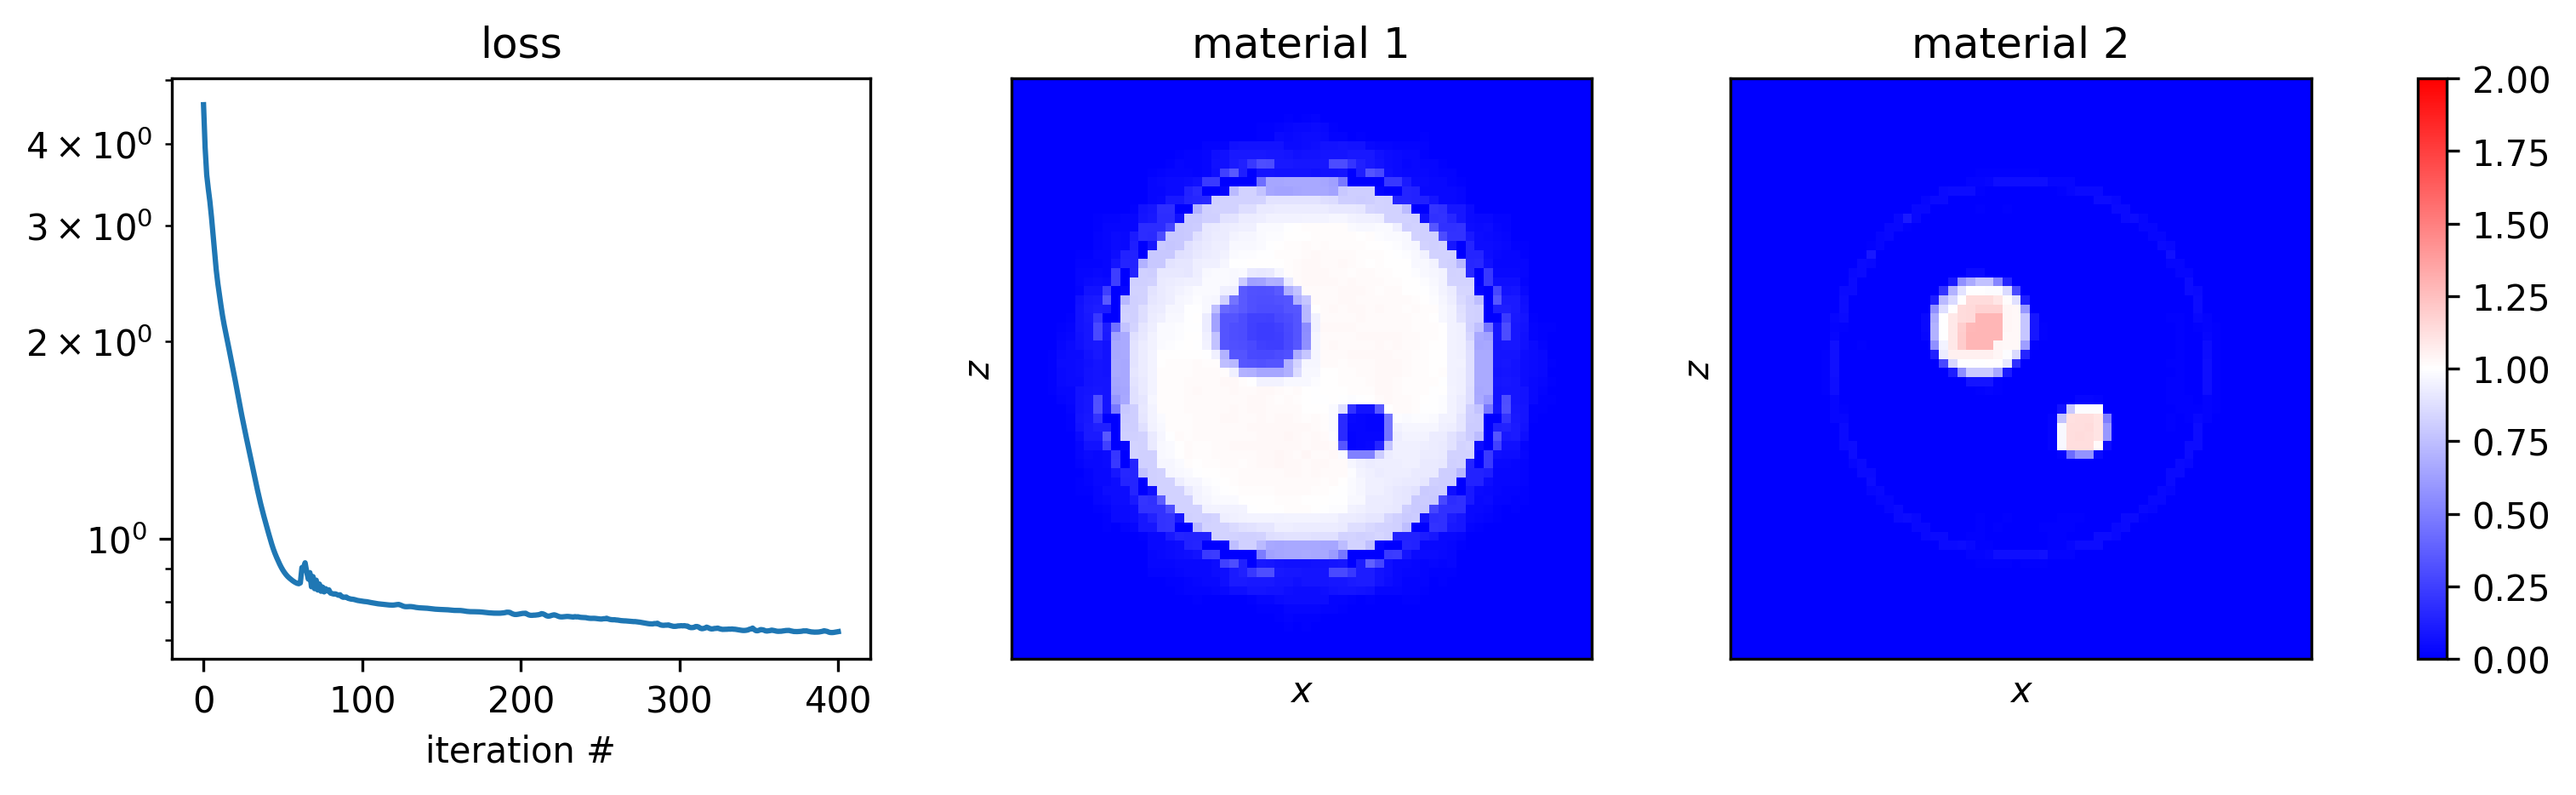

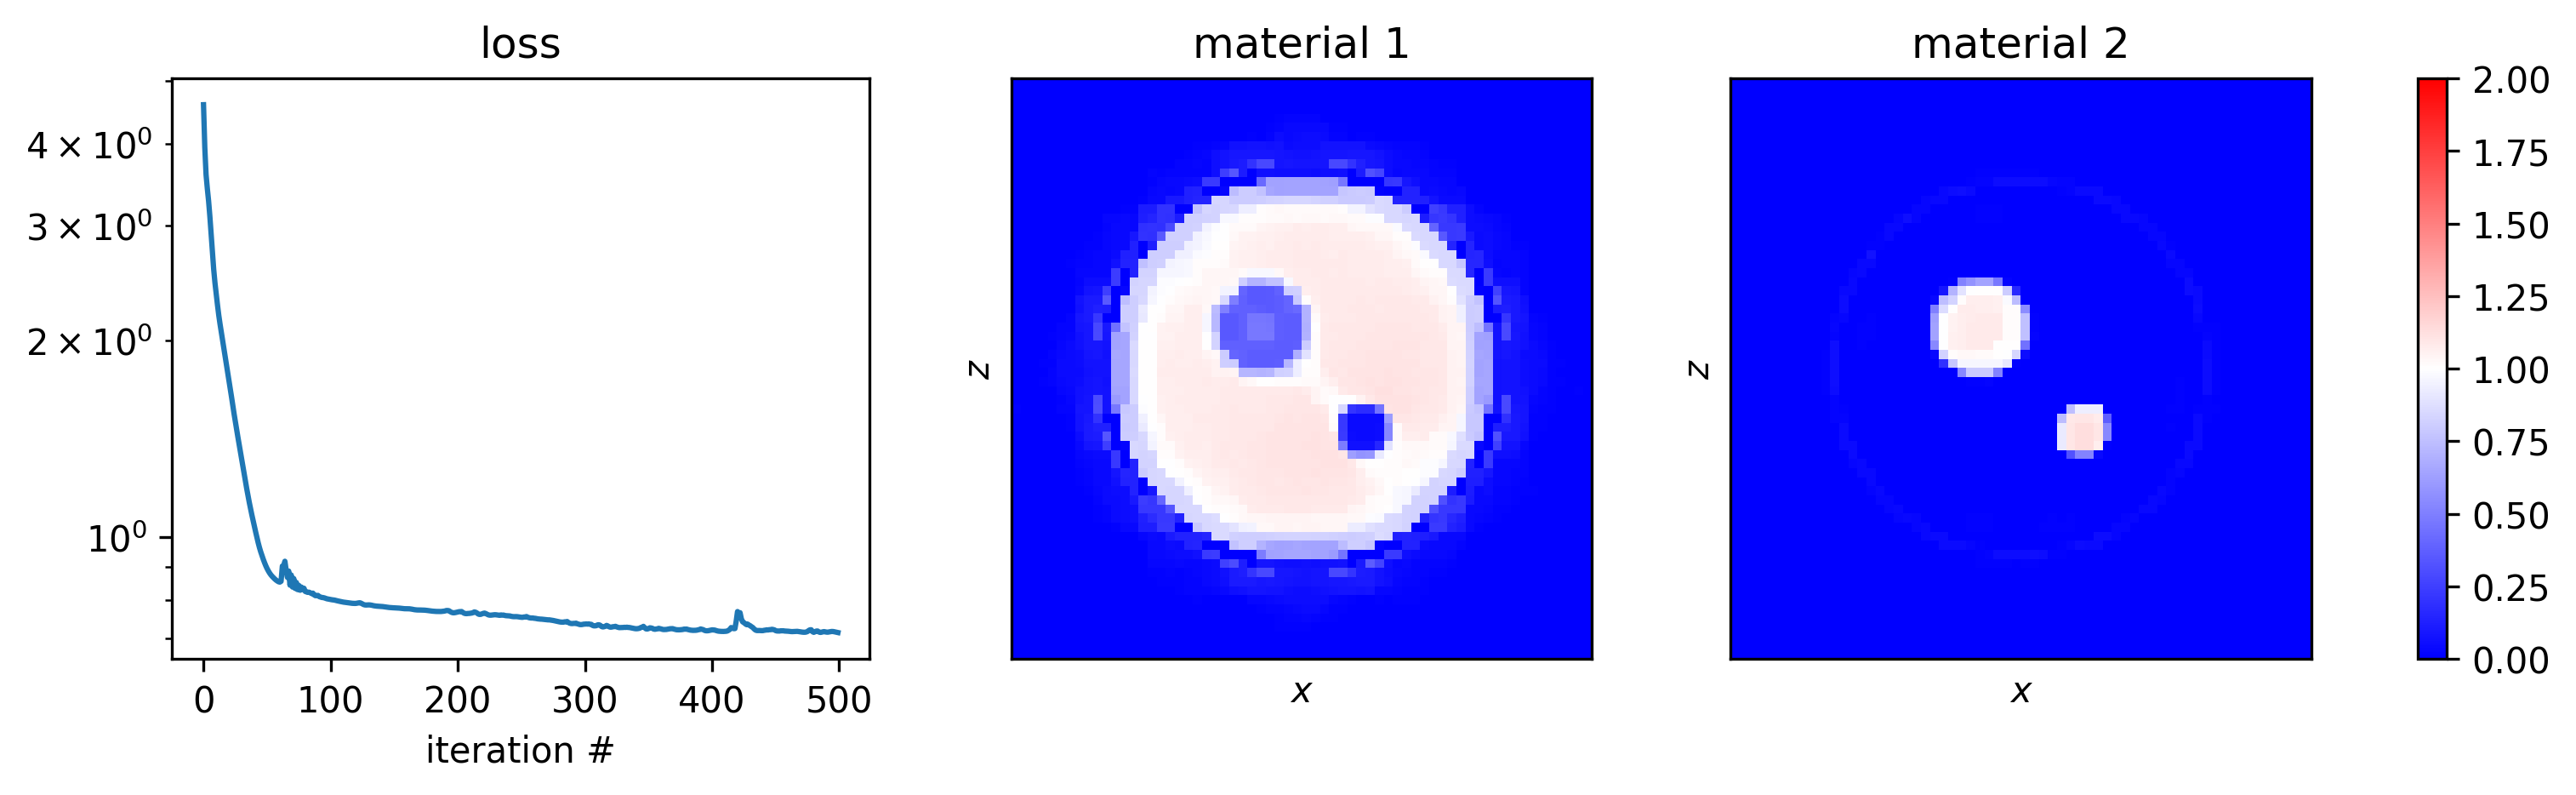

In [7]:

# optimization parameters -- these should be tuned!
LRATE = 0.04
EPS = 1e-5
w_tv_mat1 = 1e-5  
w_tv_mat2 = 1e-5
w_l1_mat1 = 5e-6  
w_l1_mat2 = 1e-4  

# maximum iterations
max_iter = 500

# Init the model
key = jax.random.PRNGKey(3)
model = MultiMatPBI()
params = model.init(key, 0)
forward = jax.vmap(model.apply, in_axes=(None, 0))  
optimizer = optax.adam(learning_rate=LRATE, eps=EPS)
opt_state = optimizer.init(params)  

# Define the loss function
def loss_fn(params, data):
    vol = params['params']['volume']
    vol1, vol2 = vol[:,:,:,0], vol[:,:,:,1]   
    y_k = forward(params, thetas)   
    loss = jnp.sqrt(jnp.sum((y_k - data)**2)) + w_tv_mat1*TV(vol1) + w_tv_mat2*TV(vol2) + w_l1_mat1*L1(vol1) + w_l1_mat2*L1(vol2)
    return loss

# Define the update function for each iteration
@jax.jit  
def update(params, opt_state, *args):
    loss, grads = jax.value_and_grad(loss_fn)(params, *args)
    updates, opt_state = optimizer.update(grads, opt_state, params,value=loss, grad=grads, value_fn=loss_fn)
    params = projection_non_negative(optax.apply_updates(params, updates))
    return params, opt_state, loss

# Run
loss = []
t0 = time()
for k in range(max_iter):
    params, opt_state, loss_k = update(params, opt_state, data)
    loss.append(loss_k)

    if (k%100 == 0):
        print(f'loss @ iter {k}: {loss_k:.3e} (t = {time()-t0:.1f} s)')
        show_compare(params, loss, density_phantom)

# Final result
show_compare(params, loss, density_phantom)